# TP : Entraînez-vous à entraîner un algorithme de Machine Learning !

## 1. Introduction 

### 1.1 Preprocess 

To begin with this problem, we will remove outliers (appartement costing more than 10 000€ / month), and we will remove appartement with missing value. 

In [1]:
data_path = "~/Documents/openclassroom/Fomation_ingenieur_ML/data/"

# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
## plot : 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 5]
## stat / model : 
from sklearn.model_selection import train_test_split


In [47]:
### EXTRACTION DATA ###
# On charge le dataset
house_data = pd.read_csv(data_path+'house_data_complete.csv')
print(house_data.head(2),"\n")

# OUTLIERS
print("Before removing outliers, there are ", house_data.shape[0], "considered appartements")
house_data = house_data[house_data['price'] < 8000]
# plt.plot(house_data['surface'], house_data['price'], 'ro', markersize=4)
# plt.show()

## REMOVING NaNs :
print("Before removing uncomplete data (NaNs), there are ", house_data.shape[0], "considered appartements")

#house_data.dropna(axis=0, how = any) 
house_data.dropna(inplace=True) 

print("After preprocessing, there are", house_data.shape[0], "considered appartements")


   price  surface  arrondissement
0   1820     46.1             1.0
1   1750     41.0             1.0 

Before removing outliers, there are  827 considered appartements
Before removing uncomplete data (NaNs), there are  817 considered appartements
After preprocessing, there are 812 considered appartements


### 1.2 First graphical analysis
My pb : the considered arrondissement are the 1,2,3,4 and 10 -> 10 gives sad color + legend ugly
It was not that easy to tackle the legend. 

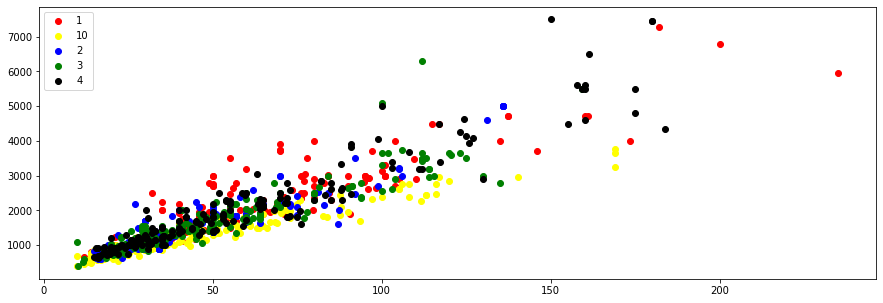

In [220]:
df = house_data.copy()
df["arr"]= df['arrondissement'].map(int).map(str)
colors = {'1':'red', '2':'blue', '3':'green', '4':'black', '10':'yellow'}
grouped = df.groupby('arr')
for key, group in grouped:
    plt.scatter(group["surface"], group["price"], label=key, color=colors[key] ) 
plt.legend()
plt.show()

We see that we have a different slopes for each arrondissement, thus it is a good idea to add this information in the linear model. Let us (as in the correction) see a boxplot in each arrondissement :

<AxesSubplot:title={'center':'surface'}, xlabel='arr'>

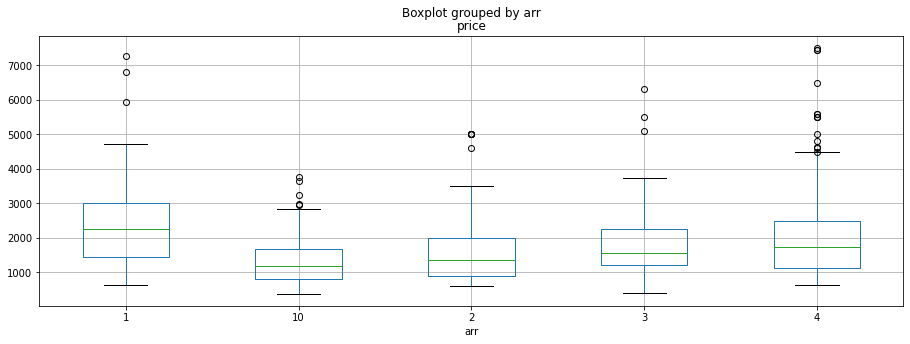

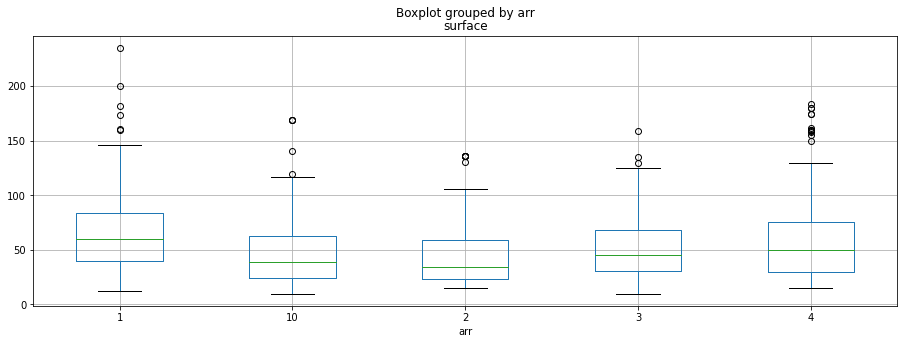

In [231]:
df.drop("arrondissement", axis=1, inplace=False).boxplot(by="arr", column="price")
df.drop("arrondissement", axis=1, inplace=False).boxplot(by="arr", column="surface")

## 2. Naive approache and first model : 

### 2.1 Construction of X matrix : 

To train our linear regression, we will need to create the $X$ matrix as : 

$$ X = \begin{pmatrix}
1 & loyer & arr_1(1) & arr_2(1) & \dots & arr_12(1)\\
& & &\dots & &  \\
1 & loyer & arr_1(i) & arr_2(i) & \dots & arr_12(i) \\
& & & \dots & &\\
1 & loyer & arr_1(n) & arr_2(n) & \dots & arr_12(n) 
\end{pmatrix} 
$$

Where 
* k = 1 ... K are the arrondissements
* i = 1 ... n are the appartements
* arr_k(i) is a boolean variable and equals to 1 if the $i^{th}$ appartement is the $k^{th}$ arrondissement, 0 otherwise. 

Indeed, the arrondissement information is a categorial info and not a numerical one. In a first approche, we will consider the arrondissement and surface without putting a weight (see after) 

So, we first need to construct the 0-1 submatrice size $k \times n$, denoted A, containing the information about arrondissement. We will first construct it with a loop and then we will use a pandas.Dataframe method to do it more properly :

In [268]:
## BY HAND METHOD : 
K = np.int(max(house_data["arrondissement"]))
n = house_data.shape[0]
A = np.zeros((n,K))

for k in range(K): 
    A[house_data["arrondissement"]==k,k]=1

TODO test unitaire : vérifier que sum(sum(A))==n

In [269]:
## WITH PANDAS METHOD : 
A = pd.get_dummies(house_data["arrondissement"],prefix="arr")

Concatenate a 1 vector, $A$ and "surface" column of data_house to get $X$

In [304]:
X = np.concatenate((np.matrix([np.ones(house_data.shape[0]), house_data['surface'].values]),A.T)).T
y = np.matrix(house_data['price']).T

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


### 2.2 Linear Regression : 

After slipping the train and test sets, I choosed the sklearn method "sklearn.linear_model.LinearRegression" and train it on data :

In [305]:
## DEFINE MODEL :
from sklearn import linear_model
regr = linear_model.LinearRegression()

## TRAINING : 
regr.fit(X_train, y_train)

LinearRegression()

In [306]:
tmp = np.concatenate((y_test.T, regr.predict(X_test).T)).T
print( pd.DataFrame(tmp,columns=["value","pred"]).head(5) )

    value         pred
0  1640.0  1760.451048
1  2483.0  3254.024129
2  2300.0  2823.836495
3  2020.0  2017.476708
4  1885.0  1757.162476


## 2. One Linear Regression for each arrondissement : 

As we know that there is a different comportement in each arrondissement, instead of training one general linear regression, I will train K=5 different linear regression as : 

<center>price$_{\text{arr} k}$ = coeff$_{\text{arr} k}$ * surface + shift$_{\text{arr}k}$ </center>

In [320]:
regr = linear_model.LinearRegression()
K = len(np.unique(house_data["arrondissement"])) # number of different arr
list_lr=[]

for j in range(K) :
    # j is the column number in X_train, see above 
    app_in_k_train = np.where(X_train[:,2+j]==1)[0]
    X_train_k = X_train[app_in_k_train,:2]
    y_train_k = y_train[app_in_k_train]
    
    regr.fit(X_train_k, y_train_k)
    
#     app_in_k_test = np.where(X_test[:,2+j]==1)[0]
#     X_test_k = X_test[app_in_k_test,:2]
#     y_test_k = y_test[app_in_k_test]
    
    list_lr.append(regr)

In [318]:
X_train[:,2:]

matrix([[0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])

In [310]:
np.where(X_train[:,2+j]==1)[0]


array([  0,   4,   5,   8,   9,  11,  15,  18,  19,  21,  22,  28,  36,
        38,  44,  47,  51,  55,  56,  57,  62,  63,  75,  78,  81,  85,
        93,  99, 109, 110, 112, 116, 117, 119, 122, 127, 133, 134, 136,
       139, 144, 151, 152, 167, 170, 172, 175, 177, 179, 181, 182, 185,
       195, 200, 204, 220, 222, 226, 238, 241, 243, 251, 259, 262, 264,
       273, 279, 282, 291, 298, 299, 300, 302, 303, 304, 312, 317, 319,
       326, 344, 352, 357, 359, 363, 371, 372, 373, 374, 379, 381, 383,
       384, 387, 389, 395, 401, 435, 436, 441, 453, 454, 455, 485, 488,
       489, 497, 500, 507, 513, 518, 521, 527, 530, 531, 536, 538, 539,
       540, 548, 551, 554, 555, 575, 584, 585, 587, 594, 601, 607, 608,
       623, 640, 642, 645])

In [277]:
X_train.shape

(649, 7)

## 3. Combined model : can we train a global linear regression ? 
### 3.1 Introducing the importance of each variable : 

Even thought the results doesn't seem that bad, I am not happy with this modelisation : I did not control how the arrondissement is important compared to the surface of the appartement. To do it, let's introduce an hyperparemeter $\mu$ that enable me to controle the weight/importance of the categorial and numerical variable. The idea is to set the better (in term of training) $\mu$ such that
<center>price = $\mu$ * surface + (1-$\mu$) * $\mathbb{1}_{\text{arrondissement}} + C^{\text{te}}$   </center>
    
As we know that the surface is really larger that 1, one can imagine that the mu parameter will be  
Note that this code is not optimized at all, but I gave some semantic variables to easy the lecture.

In [8]:
## CATEGORICAL VARIABLE MATRIX : 
A = pd.get_dummies(house_data["arrondissement"],prefix="arr")

## MODEL MATRIX WITH HYPERPARAMETER MU : 
y = np.matrix(house_data['price']).T
# semantic variables :
surface = house_data['surface'].values
shift = np.ones(house_data.shape[0])
arrondissement = A.T
      
mu = 0.5                
X_mu = np.concatenate((np.matrix([shift, mu*surface]) , (1-mu)*arrondissement)).T
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


The issue with this choise is that the train/test sets depend on mu, and it is not our aim. So I think it is a better practice to split the data independantly of mu and modify it after the X_train and X_test. That's what I do now : 

In [9]:
## CATEGORICAL VARIABLE MATRIX : 
A = pd.get_dummies(house_data["arrondissement"],prefix="arr")

## MODEL MATRIX WITH HYPERPARAMETER MU : 
y = np.matrix(house_data['price']).T
# semantic variables :
surface = house_data['surface'].values
shift = np.ones(house_data.shape[0])
arrondissement = A.T
               
X = np.concatenate((np.matrix([shift, surface]) , arrondissement)).T
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [28]:
def mu_weigth_on_X0(VarX,Varmu):
    res = VarX.copy()
    res[:,1] = Varmu*res[:,1]
    res[:,2:] = (1-Varmu)*res[:,2:]
    return(res)

def mu_weigth_on_X(VarX,Varmu):
    res = VarX.copy()
    res[:,2:] = Varmu*res[:,2:]
    return(res)

mu = 0.5
X_train_mu = mu_weigth_on_X(X_train,mu)
## TRAINING 
regr = linear_model.LinearRegression() 
regr.fit(X_train_mu, y_train)


LinearRegression()

So, we can loop on different vaues of mu to set the better model. The differents methods to split the dataset are presented after (Leave One Out, KFold, Cross Validation). I used the sklearn CV routine : 

In [29]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(regr, X_train_mu, y_train, cv=10)
print(cv_results['test_score'].mean())

0.8431654595220527


In [37]:
regr = linear_model.LinearRegression() 

mu_values = np.arange(0,10000,10)
reg_scores = []
for mu in mu_values : 
    X_train_mu = X_train.copy()
    X_train_mu[:,2:] = mu*X_train_mu[:,2:]
    #X_train_mu = mu_weigth_on_X(X_train,mu)
#     print(X_train_mu[:3,])
    ## LINEAR REGRESSION :
    #regr.fit(X_train_mu, y_train)
    cv_results = cross_validate(regr, X_train_mu, y_train, cv=10)
    
    reg_scores.append(cv_results['test_score'].mean())

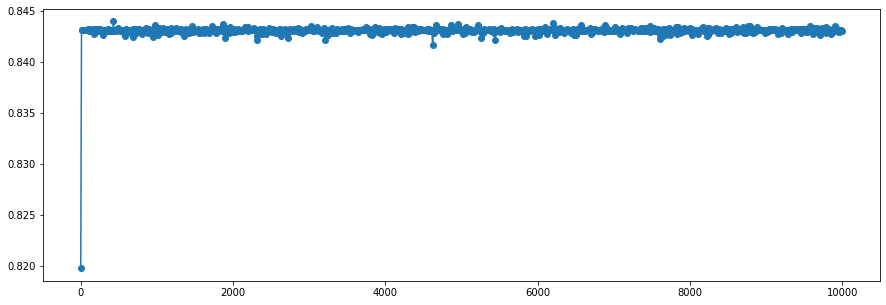

In [38]:
plt.plot(mu_values,reg_scores,'-o')

In [42]:
X_train_mu[0,]

matrix([[1.00e+00, 5.70e+01, 0.00e+00, 9.99e+03, 0.00e+00, 0.00e+00,
         0.00e+00]])

In [43]:
X_train[0,]

matrix([[ 1., 57.,  0.,  1.,  0.,  0.,  0.]])